<a href="https://colab.research.google.com/github/AswinTony2001/FinalYearProject/blob/main/FinalResNetNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

url = '/content/drive/MyDrive/Final Project Dataset'
# datasets
labels = pd.read_csv(url+"/Detection/Final Training Detection.csv")
sample = pd.read_csv(url+'/Detection/Final Training Detection.csv')
label2 = pd.read_csv(url+"/Detection/Final Testing Detection.csv")

# folders paths
train_path = url+"/Common/Training/Final Training Images"
test_path = url+"/Common/Testing/Final Testing Images"


Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Project_Dataset/Common/Training/Final Training Images"

/content/drive/MyDrive/Project_Dataset/Common/Training/Final Training Images


In [ ]:
labels.head()


,ID,cuis,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,ImageCLEFmedCaption_2022_train_000001,C0002978,C0007177,C0031050,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ImageCLEFmedCaption_2022_train_000002,C0002978,C0003489,C0175631,C0443127,C0226261,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ImageCLEFmedCaption_2022_train_000003,C0002978,C0021102,C0085590,C0232180,C0205197,C0887842,C0004704,C0021398,C0441127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ImageCLEFmedCaption_2022_train_000004,C0002978,C0013931,C0178866,C1510412,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ImageCLEFmedCaption_2022_train_000005,C0002978,C0205100,C0226463,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
classes = ["cuis"]
for i in range(2,4):
  classes.append(f"Unnamed: {i}")
labels = labels.astype(object).replace(np.nan, 'None')
labels["CombinedColumns"] = labels[classes].apply(lambda x: x.tolist(), axis=1)

In [ ]:
classes2 = ["cuis"]
for i in range(2,4):
  classes2.append(f"Unnamed: {i}")
label2 = label2.astype(object).replace(np.nan, 'None')
label2["CombinedColumns"] = label2[classes2].apply(lambda x: x.tolist(), axis=1)

In [ ]:
def to_jpg(id):
	return id+".jpg"


labels['ID'] = labels['ID'].apply(to_jpg)
sample['ID'] = sample['ID'].apply(to_jpg)
label2['ID'] = label2['ID'].apply(to_jpg)


In [ ]:
# Data agumentation and pre-processing using tensorflow
gen1 = ImageDataGenerator(
				rescale=1./255.
				)

gen2 = ImageDataGenerator(
				rescale=1./255.
				)

train_generator = gen1.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = 'ID',
	y_col = 'CombinedColumns',
	subset="training",
	color_mode="rgb",
	target_size = (255,255), # image height , image width
	class_mode="categorical",
	batch_size=10,
	shuffle=True,
	seed=42,
)


validation_generator = gen2.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = 'ID',
	y_col = 'CombinedColumns',
	subset="training",
	color_mode="rgb",
	target_size = (255,255), # image height , image width
	class_mode="categorical",
	batch_size=10,
	shuffle=True,
	seed=42,
)


Found 64994 validated image filenames belonging to 7184 classes.
Found 65000 validated image filenames belonging to 7184 classes.


In [ ]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size


(10, 255, 255, 3)

IndexError: ignored

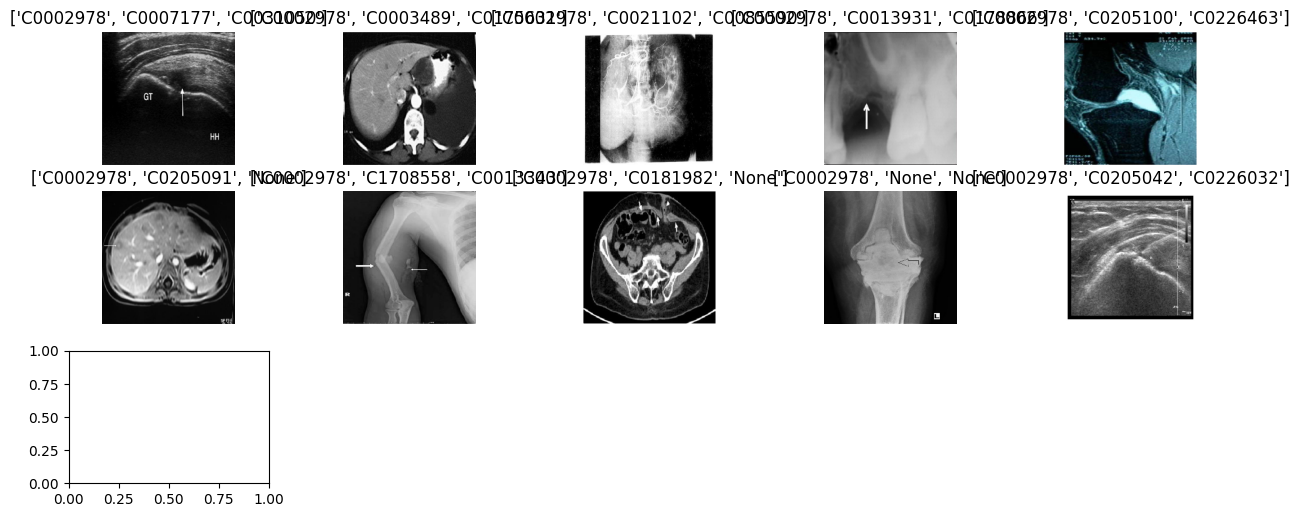

In [ ]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list


def plot_images(img, labels):
	plt.figure(figsize=[15, 10])
	for i in range(25):
		plt.subplot(5, 5, i+1)
		plt.imshow(img[i])
		plt.title(labels[i])
		plt.axis('off')

plot_images(x,labels['CombinedColumns'])


In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(255,255,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(8192, activation='relu'),
		tf.keras.layers.Dense(4096, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(2048, activation='relu'),
		# tf.keras.layers.Dense(7184, activation='softmax')
		tf.keras.layers.Dense(7184, activation='softmax')
	])


In [ ]:
model.compile(optimizer='Adagrad',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_407 (Ba  (None, 6, 6, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 8192)              12591104  
                                                                 
 dense_5 (Dense)             (None, 4096)              33558528  
                                                      

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back
checkpoint_path = "/content/drive/MyDrive/Final Project_Dataset/Models/cpRes11.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
labels1 = train_generator.classes

# print the labels
print(len(labels1[0]))

3


In [ ]:
len(validation_generator.class_indices)

7184

In [ ]:
batch_size=32
#STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# # fit model
# history = model.fit(train_generator,
# 					steps_per_epoch=10,
# 					validation_data=validation_generator,
# 					validation_steps=10,
# 					epochs=100,
# 					callbacks=[cp_callback]
# )
history = model.fit(train_generator,   #### the above commented version is ur code
					steps_per_epoch=10,
					validation_data=validation_generator,
					validation_steps=10,
					epochs=200,
					callbacks=[cp_callback]
)


Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 680.5767 - accuracy: 0.1500
Epoch 1: saving model to /content/drive/MyDrive/Final Project_Dataset/Models/cpRes11.ckpt
10/10 [==============================] - 181s 19s/step - loss: 680.5767 - accuracy: 0.1500 - val_loss: 962.4102 - val_accuracy: 0.0750
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 1433.8141 - accuracy: 0.0500
Epoch 2: saving model to /content/drive/MyDrive/Final Project_Dataset/Models/cpRes11.ckpt
10/10 [==============================] - 174s 18s/step - loss: 1433.8141 - accuracy: 0.0500 - val_loss: 2287.5093 - val_accuracy: 0.0000e+00
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 3618.8430 - accuracy: 0.0800
Epoch 3: saving model to /content/drive/MyDrive/Final Project_Dataset/Models/cpRes11.ckpt
10/10 [==============================] - 214s 22s/step - loss: 3618.8430 - accuracy: 0.0800 - val_loss: 4329.8252 - val_accuracy: 0.0100
Epoch 4/200
10/10 [=====

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-81bf987fb2cd>", line 13, in <cell line: 13>
    history = model.fit(train_generator,   #### the above commented version is ur code
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final Project Dataset/Common/Training/Final Training Images/ImageCLEFmedCaption_2022_train_035051.jpg'
Traceback (most recent call last):

  File "/us

In [ ]:
model.save("/content/drive/MyDrive/Final Project Dataset/Models/ModelRes25.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.03999999910593033\nValidation Accuracy: 0.0')

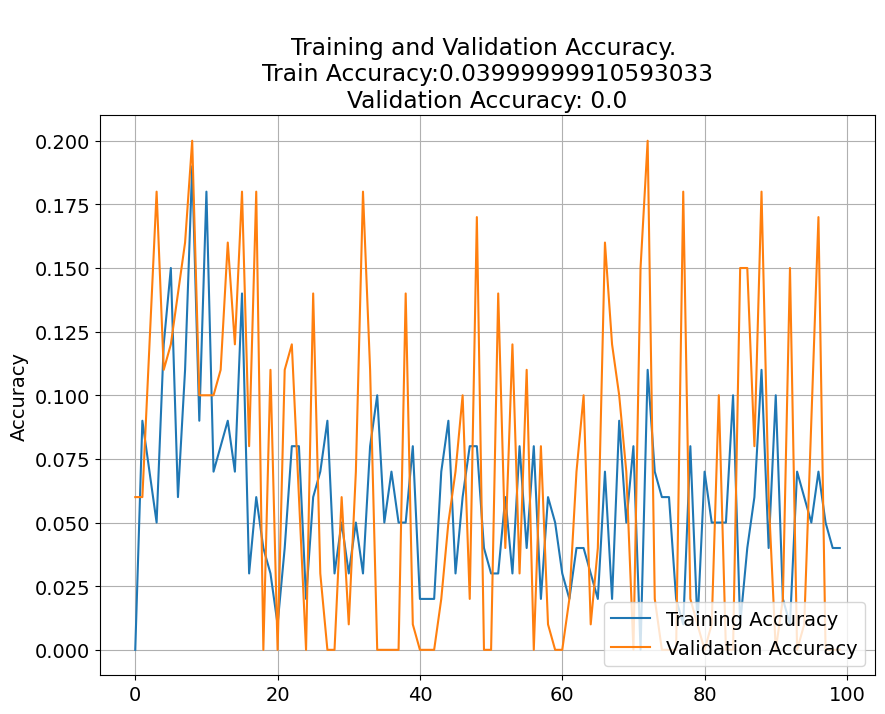

In [ ]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


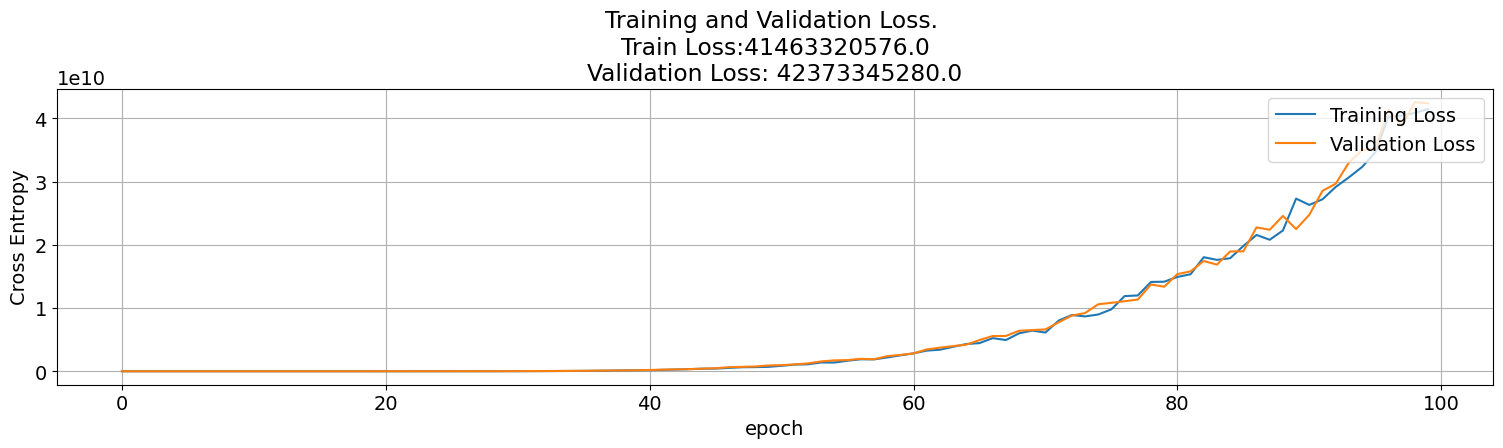

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [ ]:
#accuracy_score = model.evaluate(validation_generator)
#print(accuracy_score)
#print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

#print("Loss: ",accuracy_score[0])


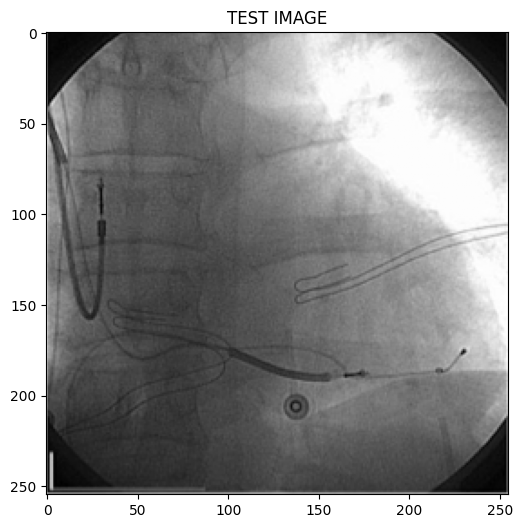

In [ ]:
test_img_path = test_path+"/ImageCLEFmedCaption_2022_train_065401.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (255, 255)).reshape(-1, 255, 255, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])


In [ ]:
predictions = []
predictions1 = []
i = 0
model1 = keras.models.load_model("/content/drive/MyDrive/Final Project Dataset/Models/ModelRes25.h5")
img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (255, 255))
img = tf.reshape(img, (-1, 255, 255, 3))
prediction = model1.predict(img)
print(prediction)
#print(prediction[0].count_nonzero(x==1))
predictions.append(list(prediction[0]))
print(predictions)
top_3_idx = np.argsort(prediction[0])[-3:] 
print(top_3_idx)

#main_dict = validation_generator.class_indices
#def threshold(thres,output):
#  actual = []
#  j = 0
#  for i in range(len(output[0])):
#    if(output[0][i]>=thres):
#      actual.append(list(main_dict.keys())[i])
#  return actual

#predictions1 = threshold(1.,predictions)

my_submission = {'ID': 'ImageCLEFmedCaption_2022_test_065401', 'cuis': top_3_idx}
#my_submission.to_csv('submission.csv', index=False)

# Submission file ouput
print("Submission File: \n---------------\n")
print(predictions1)
print(my_submission) # Displaying first five predicted output


1/1 [==============================] - 5s 5s/step
[[0. 0. 0. ... 0. 0. 0.]]
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
predictions = []
predictions1 = []
predictions2 = []
i = 0

for image in label2.ID:
  if i != 18275:
    main_dict = validation_generator.class_indices
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (255, 255))
    img = tf.reshape(img, (-1, 255, 255, 3))
    prediction = model.predict(img/255)
    #print(prediction)
    predictions.append(list(prediction[0]))
    #print(predictions)
    predictions2.append(np.argsort(prediction[0])[-3:]) 
    #print(predictions2)


    #predictions.append(np.argmax(prediction))
    #print(predictions)
    #def threshold(thres,output):
    #  actual = []
    #  j = 0
    #  for i in range(output[0]):
    #    if(output[0]>=thres):
    #      actual.append(list(main_dict.keys())[i])
    #    top_3_idx = np.argsort(actual[0])[-3:] 
    #  return top_3_idx
    #predictions1 = threshold(0.1,predictions)
    #print(predictions1)
    i = i+1
my_submission = pd.DataFrame({'ID': label2.ID, 'cuis': predictions2})
# my_submission.to_csv('/content/drive/MyDrive/Final Project Dataset/Models/submission1.csv', index=False)
my_submission.to_csv('/content/drive/MyDrive/Final Project Dataset/Models/submission12.csv', index=False)


# Submission file output
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 3s 3s/step


In [ ]:
mapping_df = pd.read_csv('/content/drive/MyDrive/Final Project Dataset/Detection/72d678c1-c535-491d-bc42-c2ba11f47165_concepts.csv')

In [ ]:
Modality_Mapping = dict()
k = 0
l = 0
predictions = []
predictions1 = []
predictions2 = []
predictions4 = []
predictions5 = []
predictions6 = []
predictions7 = []
predictions3 = pd.read_csv("/content/drive/MyDrive/Final Project Dataset/Models/submission12.csv")
for i in range(0,5000):
  predictions4 = predictions3['cuis'][i].split()
  if k == 0:  
    predictions4.remove('[')
  else:
    predictions4[0] = predictions4[0].replace('[','')
  predictions4[2] = predictions4[2].replace(']','')
  predictions5.append(predictions4)  
  k = k + 1
for i in mapping_df.index:
  Modality_Mapping[mapping_df['concept'][i]] = mapping_df['concept_name'][i]
for x in range(0,5000):
  p =0
  for j in mapping_df.index:
    if str(j) == predictions5[x][1] or str(j) == predictions5[x][2]:
      if x >= 0 and x <= 500 and p == 0:
        predictions1.append(2300) 
        predictions2.append(mapping_df['concept'][2300])
        predictions.append(mapping_df['concept_name'][2300])
        p = p+1 
      if x >= 301 and x <= 5000 and p == 0:
        predictions1.append(8123) 
        predictions2.append(mapping_df['concept'][8123])
        predictions.append(mapping_df['concept_name'][8123])
        p = p+1 
      predictions1.append(j) 
      predictions2.append(mapping_df['concept'][j])
      predictions.append(mapping_df['concept_name'][j]) 

def split(list_a, chunk_size):
  for i in range(0, len(list_a), chunk_size):
    yield list_a[i:i + chunk_size]

chunk_size = 3
predictions6 = list(split(predictions2, chunk_size))
predictions7 = list(split(predictions, chunk_size))

In [ ]:
print(predictions6[302])
print(predictions7[302])

['C0002978', 'C0028879', 'C1710048']
['angiogram', 'Odontogenic Cysts', 'Semi-Circle']


In [ ]:
print(labels['CombinedColumns'][5])
print(predictions6[5])

['C0002978', 'C0205091', 'None']
['C0002978', 'C0205122', 'C0180479']


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer

predictions3 = pd.read_csv("/content/drive/MyDrive/Final Project Dataset/Models/submission12.csv")
# define true labels
true_labels = ["a", "c", "b", "a"]

# define corresponding predicted labels
pred_labels = ["c", "c", "b", "a"]
score = []
acc1 = []
prec1 = []
rec1 = []
for x in range(0,5000):
  #print(labels['CombinedColumns'][x])
  #print(predictions5[x])
  score.append(f1_score(label2['CombinedColumns'][x],predictions6[x], average="macro"))
  acc1.append(accuracy_score(label2['CombinedColumns'][x],predictions6[x]))
  prec1.append(precision_score(label2['CombinedColumns'][x],predictions6[x],average="weighted"))
  rec1.append(recall_score(label2['CombinedColumns'][x],predictions6[x],average="micro"))

def Average(lst):
    return sum(lst) / len(lst)

averageF1 = Average(score)
averageacc1 = Average(acc1)
averageprec1 = Average(prec1)
averagerec1 = Average(rec1)
print(averageF1)
print(averageacc1)
print(averageprec1)
print(averagerec1)
#score = f1_score(true_labels, pred_labels, average="micro")
#print("Micro F1-Score: ", score)

#score = f1_score(true_labels, pred_labels, average="weighted")
#print("Weighted F1-Score: ", score)

0.2037200000000169
0.33199999999998037
0.33199999999998037
0.33199999999998037
